<br>

<div align=center><font color=maroon size=6 style="line-height:40px;"><b>Action Recognition with an Inflated 3D CNN</b></font></div>

<br>

<font size=4><b>References:</b></font>
1. TensorFlow > <a href="https://www.tensorflow.org/resources" style="text-decoration:none;">Resources</a> 
    * `TensorFlow > Resources > Hub > Tutorials > `<a href="https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub" style="text-decoration:none;">Action Recognition with an Inflated 3D CNN</a>
        * Run in <a href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/action_recognition_with_tf_hub.ipynb" style="text-decoration:none;">Google Colab</a>

<br>
<br>
<br>

<font style="color:maroon;font-size:120%;line-height:30px">This Colab demonstrates recognizing actions in video data using the
[tfhub.dev/deepmind/i3d-kinetics-400/1](https://tfhub.dev/deepmind/i3d-kinetics-400/1) module. More models to detect actions in videos can be found [here](https://tfhub.dev/s?module-type=video-classification).

The underlying model is described in the paper "[Quo Vadis, Action Recognition? A New
Model and the Kinetics Dataset](https://arxiv.org/abs/1705.07750)" by Joao
Carreira and Andrew Zisserman. The paper was posted on arXiv in May 2017, and
was published as a CVPR 2017 conference paper.
The source code is publicly available on
[github](https://github.com/deepmind/kinetics-i3d).</font>

"Quo Vadis" introduced a new architecture for video classification, the **Inflated
3D Convnet** or **I3D**. This architecture achieved state-of-the-art results on the UCF101
and HMDB51 datasets from fine-tuning these models. I3D models pre-trained on Kinetics
also placed first in the CVPR 2017 [Charades challenge](http://vuchallenge.org/charades.html).

The original module was trained on the [kinetics-400 dateset](https://www.deepmind.com/open-source/kinetics)
and knows about 400 different actions.
Labels for these actions can be found in the
[label map file](https://github.com/deepmind/kinetics-i3d/blob/master/data/label_map.txt).

In this Colab we will use it recognize activites in videos from a UCF101 dataset.

<br>

## Setup

In [1]:
# !pip install -q imageio
# !pip install -q opencv-python
# !pip install -q git+https://github.com/tensorflow/docs

<br>
<br>

### Import the necessary modules

In [2]:
#@title Import the necessary modules
# TensorFlow and TF-Hub modules.

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

from absl import logging
logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import os
import re
import random
import ssl
import cv2
import tempfile
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [3]:
print(tf.__version__)

2.8.0


<br>
<br>

### Helper functions for the UCF101 dataset

In [4]:
#@title Helper functions for the UCF101 dataset
# Utilities to fetch videos from UCF101 dataset

In [5]:
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
print(_CACHE_DIR)

C:\Users\18617\AppData\Local\Temp\tmp_jb0htnm


In [6]:
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
    """Lists videos available in UCF101 dataset."""
    global _VIDEO_LIST
    if not _VIDEO_LIST:
        index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
        videos = re.findall("(v_[\w_]+\.avi)", index)
        _VIDEO_LIST = sorted(set(videos))
    return list(_VIDEO_LIST)



def fetch_ucf_video(video):
    """Fetchs a video and cache into local filesystem."""
    cache_path = os.path.join(_CACHE_DIR, video)
    if not os.path.exists(cache_path):
        urlpath = request.urljoin(UCF_ROOT, video)
        
        print("Fetching %s => %s" % (urlpath, cache_path))
        data = request.urlopen(urlpath, context=unverified_context).read()
        open(cache_path, "wb").write(data)
    return cache_path

In [7]:
# Utilities to open video files using CV2
def crop_center_square(frame):
    print("Original frame shape: ", frame.shape)    # 陈锐平添加
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    
    return frame[start_y:start_y+min_dim, start_x:start_x+min_dim]



def load_video(path, max_frames=0, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    
    return np.array(frames) / 255.0



def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./gif/animation.gif', converted_images, fps=25)
    
    return embed.embed_file('./gif/animation.gif')

<br>
<br>

### Get the kinetics-400 labels

In [8]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
    labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))


# 这里如果不翻墙的话，也会因网络问题而报错。

Found 400 labels.


<br>

## Using the UCF101 dataset

In [9]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()
  
categories = {}
for video in ucf_videos:
    category = video[2:-12]
    if category not in categories:
        categories[category] = []
    categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
    summary = ", ".join(sequences[:2])
    print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))

Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              

<br>

In [10]:
# Get a sample cricket video.
video_path = fetch_ucf_video("v_CricketShot_g04_c02.avi")
sample_video = load_video(video_path)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_CricketShot_g04_c02.avi => C:\Users\18617\AppData\Local\Temp\tmp_jb0htnm\v_CricketShot_g04_c02.avi
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240, 320, 3)
Original frame shape:  (240,

<br>

In [11]:
sample_video.shape

(116, 224, 224, 3)

<br>
<br>
<br>

In [12]:
# i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']
# 
# 总是在这里无限运行。于是将该模型 i3d-kinetics-400_1.tar.gz 下载在路径下：
# D:/KeepStudy/0_Coding/1_tf_models/
# 即：D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1.tar.gz# 即：

In [13]:
# help(hub.load)
# help(hub.Module)
# help(hub.resolve)

In [14]:
# 下面的尝试均已报错告终


# import tensorflow as tf
# import tensorflow_hub as hub

# i3d = hub.load("D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1.tar.gz")
# 报错：
# OSError: SavedModel file does not exist at: 
# D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1.tar.gz\{saved_model.pbtxt|saved_model.pb}



# i3d = hub.load("D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1")
# 这一句总是会导致：The kernel appears to have died. It will restart automatically.


# i3d = hub.KerasLayer("D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1")
# 这一句总是会导致：The kernel appears to have died. It will restart automatically.


# i3d = tf.keras.models.load_model("D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1")
# 
# WARNING:tensorflow:SavedModel saved prior to TF 2.5 detected when loading Keras model. 
# Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), 
# *NOT* tf.saved_model.save(). 
# To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
# 并且最终报错：
# IndexError: list index (0) out of range



# i3d = tf.saved_model.load("D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1")
#
# ValueError: Importing a SavedModel with `tf.saved_model.load` requires a `tags=` argument 
# if there is more than one MetaGraph. Got `tags=None`, 
# but there are 2 MetaGraphs in the SavedModel with tag sets: [[], ['train']]. 
# Pass a `tags=` argument to load this SavedModel.

In [17]:
i3d_download_path = hub.resolve("D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1")
print(i3d_download_path)

i3d_download = hub.load(i3d_download_path)
print(type(i3d_download))
print()




i3d_temp_path = hub.resolve("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
# 后来发现，这种方式需要先运行：
# hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']
# 以便在 C:\Users\18617\AppData\Local\Temp 建立缓存 tfhub_modules\092225fb776e28d6d64ac605ab6be03f18dd2027
# 然后 hub.resolve("https://tfhub.dev/deepmind/i3d-kinetics-400/1") 才能正常运行。
print(i3d_temp_path)

i3d = hub.load(i3d_temp_path)
print(type(i3d))


# 参考链接：
# 路线 1：（采用）
# https://tensorflow.google.cn/hub/common_issues#tf2_savedmodels
# https://tensorflow.google.cn/hub/caching
# 
# 路线 2：（未尝试）
# https://xianbao-qian.medium.com/how-to-run-tf-hub-locally-without-internet-connection-4506b850a915



# 但是，在后面的 cell 执行
# i3d(model_input)['default'][0]
# 将会报错：
# TypeError: 'AutoTrackable' object is not callable
# 解决方案：添加 .signatures['default']
# 参考链接：https://stackoverflow.com/questions/59471873/autotrackable-object-is-not-callable-in-python
# 具体如下个 cell 所示。

D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1
<class 'tensorflow.python.training.tracking.autotrackable.AutoTrackable'>

C:\Users\18617\AppData\Local\Temp\tfhub_modules\092225fb776e28d6d64ac605ab6be03f18dd2027
<class 'tensorflow.python.training.tracking.autotrackable.AutoTrackable'>


<br>

In [21]:
i3d_download_path = hub.resolve("D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1")
print(i3d_download_path)

i3d_download = hub.load(i3d_download_path).signatures['default']
print(type(i3d_download))
print()



i3d_temp_path = hub.resolve("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
print(i3d_temp_path)

i3d = hub.load(i3d_temp_path).signatures['default']
print(type(i3d))

D:/KeepStudy/0_Coding/1_tf_models/i3d-kinetics-400_1
<class 'tensorflow.python.eager.wrap_function.WrappedFunction'>

C:\Users\18617\AppData\Local\Temp\tfhub_modules\092225fb776e28d6d64ac605ab6be03f18dd2027
<class 'tensorflow.python.eager.wrap_function.WrappedFunction'>


<br>

Run the id3 model and print the top-5 action predictions.

In [22]:
def predict(sample_video):
    # Add a batch axis to the sample video.
    model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

    logits = i3d(model_input)['default'][0]
    probabilities = tf.nn.softmax(logits)

    print("Top 5 actions:")
    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [23]:
predict(sample_video)

Top 5 actions:
  playing cricket       : 97.78%
  skateboarding         :  0.70%
  robot dancing         :  0.56%
  roller skating        :  0.55%
  golf putting          :  0.13%


<br>

Now try a new video, from: https://commons.wikimedia.org/wiki/Category:Videos_of_sports

How about [this video](https://commons.wikimedia.org/wiki/File:End_of_a_jam.ogv) by Patrick Gillett: 

In [20]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 55.0M    0 13447    0     0   5422      0  2:57:34  0:00:02  2:57:32  5419
  0 55.0M    0  142k    0     0  42030      0  0:22:54  0:00:03  0:22:51 42018
  0 55.0M    0  461k    0     0  94520      0  0:10:11  0:00:04  0:10:07 94520
  1 55.0M    1  716k    0     0   132k      0  0:07:06  0:00:05  0:07:01  142k
  2 55.0M    2 1417k    0     0   217k      0  0:04:19  0:00:06  0:04:13  288k
  2 55.0M    2 1608k    0     0   212k      0  0:04:25  0:00:07  0:04:18  313k
  5 55.0M    5 2851k    0     0   334k      0  0:02:48  0:00:08  0:02:40  535k
  6 55.0M    6 3680k    0     0   369k      0  0:02

 90 55.0M   90 49.8M    0     0   198k      0  0:04:44  0:04:17  0:00:27 42279
 90 55.0M   90 49.9M    0     0   198k      0  0:04:44  0:04:18  0:00:26 69644
 90 55.0M   90 50.0M    0     0   197k      0  0:04:45  0:04:19  0:00:26 55744
 90 55.0M   90 50.0M    0     0   196k      0  0:04:46  0:04:20  0:00:26 53464
 90 55.0M   90 50.1M    0     0   195k      0  0:04:48  0:04:21  0:00:27 41685
 91 55.0M   91 50.1M    0     0   195k      0  0:04:48  0:04:22  0:00:26 55288
 91 55.0M   91 50.1M    0     0   194k      0  0:04:49  0:04:23  0:00:26 35725
 91 55.0M   91 50.2M    0     0   194k      0  0:04:50  0:04:24  0:00:26 39285
 91 55.0M   91 50.2M    0     0   193k      0  0:04:51  0:04:25  0:00:26 41443
 91 55.0M   91 50.3M    0     0   193k      0  0:04:51  0:04:26  0:00:25 50281
 91 55.0M   91 50.3M    0     0   192k      0  0:04:52  0:04:27  0:00:25 38888
 91 55.0M   91 50.3M    0     0   192k      0  0:04:53  0:04:28  0:00:25 48417
 91 55.0M   91 50.4M    0     0   191k      0  0:04:

<br>
<br>

In [24]:
video_path = "End_of_a_jam.ogv"

In [25]:
sample_video = load_video(video_path)[:100]
sample_video.shape

Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original fra

Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original fra

Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original fra

Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original frame shape:  (810, 1920, 3)
Original fra

(100, 224, 224, 3)

<br>
<br>

In [27]:
sample_video  # 陈锐平添加

array([[[[0.42745098, 0.43529412, 0.37647059],
         [0.43137255, 0.42745098, 0.38431373],
         [0.43137255, 0.42745098, 0.38431373],
         ...,
         [0.28627451, 0.34901961, 0.36078431],
         [0.27843137, 0.35294118, 0.36470588],
         [0.2745098 , 0.34117647, 0.35686275]],

        [[0.42745098, 0.43137255, 0.38431373],
         [0.43137255, 0.42745098, 0.38431373],
         [0.43137255, 0.42745098, 0.38431373],
         ...,
         [0.25882353, 0.31764706, 0.32156863],
         [0.27058824, 0.32941176, 0.34117647],
         [0.2745098 , 0.35294118, 0.35686275]],

        [[0.43137255, 0.42745098, 0.39215686],
         [0.43529412, 0.43137255, 0.40392157],
         [0.43137255, 0.42745098, 0.4       ],
         ...,
         [0.23921569, 0.28235294, 0.27843137],
         [0.25490196, 0.29803922, 0.29803922],
         [0.25882353, 0.31764706, 0.32941176]],

        ...,

        [[0.69803922, 0.64313725, 0.45098039],
         [0.69411765, 0.62352941, 0.45098039]

<br>
<br>


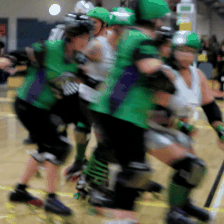

In [28]:
to_gif(sample_video)

In [29]:
predict(sample_video)

Top 5 actions:
  roller skating        : 96.83%
  playing volleyball    :  1.64%
  skateboarding         :  0.22%
  playing ice hockey    :  0.20%
  playing basketball    :  0.16%


<br>

<br>
<br>
<br>